In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 10)
!date

%load_ext autoreload
%autoreload 2

Tue Jul 23 11:31:36 PDT 2019


# Consistent models in DisMod-MR from Vivarium artifact draw

Take i, r, f, p from a Vivarium artifact, and make a consistent version of them.  See how it compares to the original.

In [2]:
np.random.seed(123456)

In [3]:
# if dismod_mr is not installed, it should possible to use
# !conda install --yes pymc
# !pip install dismod_mr

In [4]:
import dismod_mr

In [5]:
# you also need one more pip installable package
# !pip install vivarium_public_health

In [6]:
import vivarium_public_health

# Consistent fit with all data

Let's start with a consistent fit of the simulated PD data.  This includes data on prevalence, incidence, and SMR, and the assumption that remission rate is zero.  All together this counts as four different data types in the DisMod-II accounting.

In [7]:
from vivarium_public_health.dataset_manager import Artifact
art = Artifact('/share/costeffectiveness/artifacts/obesity/obesity.hdf')

In [8]:
art.keys

[EntityKey(metadata.keyspace),
 EntityKey(metadata.versions),
 EntityKey(metadata.locations),
 EntityKey(population.demographic_dimensions),
 EntityKey(population.structure),
 EntityKey(cause.all_causes.cause_specific_mortality),
 EntityKey(population.theoretical_minimum_risk_life_expectancy),
 EntityKey(cause.ischemic_heart_disease.restrictions),
 EntityKey(cause.ischemic_stroke.restrictions),
 EntityKey(cause.diabetes_mellitus_type_2.restrictions),
 EntityKey(cause.asthma.restrictions),
 EntityKey(cause.gout.restrictions),
 EntityKey(cause.osteoarthritis.restrictions),
 EntityKey(cause.chronic_kidney_disease_due_to_hypertension.restrictions),
 EntityKey(cause.chronic_kidney_disease_due_to_glomerulonephritis.restrictions),
 EntityKey(cause.chronic_kidney_disease_due_to_other_and_unspecified_causes.restrictions),
 EntityKey(cause.chronic_kidney_disease_due_to_diabetes_mellitus_type_2.restrictions),
 EntityKey(risk_factor.high_body_mass_index_in_adults.exposure),
 EntityKey(risk_factor.

In [9]:
def format_for_dismod(df, data_type):
    df = df.query('draw==0 and sex=="Female" and year_start==2017').copy()
    df['data_type'] = data_type
    df['area'] = 'all'
    df['standard_error'] = 0.001
    df['upper_ci'] = np.nan
    df['lower_ci'] = np.nan
    df['effective_sample_size'] = 10_000

    df['sex'] = 'total'
    df = df.rename({'age_group_start': 'age_start',
                                     'age_group_end': 'age_end',}, axis=1)
    return df

p = format_for_dismod(art.load('cause.ischemic_heart_disease.prevalence'), 'p')

In [10]:
i = format_for_dismod(art.load('cause.ischemic_heart_disease.incidence'), 'i')

In [11]:
f = format_for_dismod(art.load('cause.ischemic_heart_disease.excess_mortality'), 'f')

In [12]:
m_all = format_for_dismod(art.load('cause.all_causes.cause_specific_mortality'), 'm_all')

In [13]:
csmr = format_for_dismod(art.load('cause.ischemic_heart_disease.cause_specific_mortality'), 'csmr') # could also try 'pf'

In [14]:
dm = dismod_mr.data.ModelData()
dm.input_data = pd.concat([p, i, f, m_all,
                          csmr
                          ], ignore_index=True)
for rate_type in 'ifr':
    dm.set_knots(rate_type, [0,40,60,80,90,100])

dm.set_level_value('i', age_before=30, age_after=101, value=0)
dm.set_increasing('i', age_start=50, age_end=100)

dm.set_level_value('p', value=0, age_before=30, age_after=101)

dm.set_level_value('r', value=0, age_before=101, age_after=101)

In [15]:
dm.input_data.data_type.value_counts()

m_all    23
f        23
p        23
csmr     23
i        23
Name: data_type, dtype: int64

In [16]:
dm.setup_model(rate_model='normal', include_covariates=False)

/ihme/homes/abie/.local/lib/python3.6/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/ihme/homes/abie/.local/lib/python3.6/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [17]:
import pymc as pm
m = pm.MAP(dm.vars)

In [18]:
%%time
m.fit(verbose=1)

Current log-probability : 1347.572455
Current log-probability : 1377.997951
Current log-probability : 1396.019187
Current log-probability : 1400.324203
Current log-probability : 1400.952332
Current log-probability : 1401.056619
Optimization terminated successfully.
         Current function value: -1401.056619
         Iterations: 6
         Function evaluations: 7548
CPU times: user 26.7 s, sys: 43.6 ms, total: 26.7 s
Wall time: 26.7 s


In [19]:
from IPython.core.pylabtools import figsize
figsize(11, 5.5)

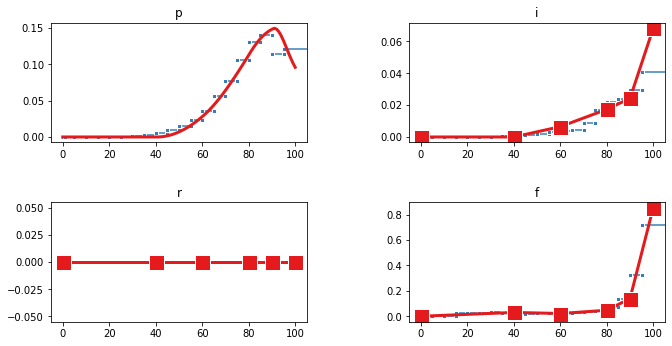

In [20]:
dm.plot()

In [21]:
!date

Tue Jul 23 11:33:23 PDT 2019
